# Twitch GCN Experiments — Part 2
### Graph Neural Networks for Node Classification, Transfer Learning & Link Prediction
**Authors:** Hadiqa Alamdar Bukhari and Marwah Sulaiman

---

## From Part 1 to Part 2: The Research Question

In Part 1, we analysed the Twitch Gamers Social Network using classical graph methods. Our key findings were:

- The dataset contains **5 completely disconnected language communities** (DE, ENGB, ES, FR, RU) — there are no edges between them
- We computed **centrality measures per language** because cross-language distances are undefined
- **Community detection** (Louvain, Leiden, Label Propagation) revealed that each language has distinct internal structure, with modularity ranging from ~0.30 (FR, weakest) to ~0.47 (ENGB, strongest)
- **FR stood out as anomalous**: lowest modularity, weakest community structure, most mixed internal topology

This raises a natural question that classical methods cannot answer:

> *The 5 language networks share no edges, but they do share a common vocabulary of 3,170 games. Can a model trained on one language community generalise to predict streamer behaviour in another?*

Part 2 answers this using **Graph Convolutional Networks (GCNs)**. The shared game-feature space acts as the cross-language bridge that the graph structure lacks. We run two experiments:
1. **Transfer Learning** — train on one language, predict mature content in all others
2. **Link Prediction** — predict friendships within each language community

We also connect back to Part 1 by measuring whether the GCN's learned representations recover the same communities that Louvain and Leiden found classically.

## Setup & Imports

We use **PyTorch Geometric** for GCN layers and graph data structures, **scikit-learn** for evaluation metrics and baselines, and standard scientific Python libraries for data handling and visualisation.

MPS (Apple Silicon GPU) is used where available for faster training.

In [9]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


# ──────────────────────────────────────────────────────────────────────────────
#  CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────

DATA_DIR = "twitch"  # relative to project root
LANGUAGES = ["DE", "ENGB", "ES", "FR", "RU"]
VOCAB_SIZE = 3170  # max game-feature ID across all languages + 1

# JSON feature filenames differ for DE vs others
FEATURE_FILES = {
    "DE": "musae_DE.json",
    "ENGB": "musae_ENGB_features.json",
    "ES": "musae_ES_features.json",
    "FR": "musae_FR_features.json",
    "RU": "musae_RU_features.json",
}

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")
DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## 1. Dataset

### Structure
Each language network is stored as separate CSV files (edges + node attributes) and a JSON file of game features. We load all 5 into PyTorch Geometric `Data` objects.

### Node Features: The Cross-Language Bridge
Each node is represented as a **3,170-dimensional multi-hot vector** where each dimension corresponds to a game in the global vocabulary. If a streamer has streamed that game, the entry is 1, otherwise 0.

This shared feature space is the critical design choice that makes transfer learning possible: even though DE and ES share no edges, a German streamer and a Spanish streamer who both play the same games will have similar feature vectors. The GCN can exploit this.

### Target Label
`mature` — binary flag indicating whether the streamer uses explicit language. This is what we are trying to predict.

In [10]:
# ──────────────────────────────────────────────────────────────────────────────
#  1. DATA LOADING
# ──────────────────────────────────────────────────────────────────────────────

def load_language_graph(lang: str) -> Data:
    """
    Load a single language's graph as a PyG Data object.

    Returns Data with:
      - x:          [num_nodes, 3170]  multi-hot game features
      - edge_index: [2, num_edges]     undirected friendships
      - y:          [num_nodes]        binary labels (mature)
      - num_nodes:  int
    """
    base = os.path.join(DATA_DIR, lang)

    # ── Load target CSV ──────────────────────────────────────────────────
    target_df = pd.read_csv(os.path.join(base, f"musae_{lang}_target.csv"))
    # Sort by new_id so node indices align
    target_df = target_df.sort_values("new_id").reset_index(drop=True)
    num_nodes = len(target_df)

    # Binary labels: mature (True/False -> 1/0)
    labels = target_df["mature"].astype(int).values
    y = torch.tensor(labels, dtype=torch.long)

    # ── Load edges ───────────────────────────────────────────────────────
    edges_df = pd.read_csv(os.path.join(base, f"musae_{lang}_edges.csv"))
    src = edges_df["from"].values
    dst = edges_df["to"].values
    # Make undirected (add reverse edges)
    edge_index = torch.tensor(
        np.stack([np.concatenate([src, dst]), np.concatenate([dst, src])]),
        dtype=torch.long,
    )

    # ── Load game features (JSON -> multi-hot) ──────────────────────────
    feat_file = os.path.join(base, FEATURE_FILES[lang])
    with open(feat_file) as f:
        features_raw = json.load(f)

    x = torch.zeros((num_nodes, VOCAB_SIZE), dtype=torch.float)
    for node_id_str, feat_ids in features_raw.items():
        node_idx = int(node_id_str)
        if node_idx < num_nodes:
            for fid in feat_ids:
                if fid < VOCAB_SIZE:
                    x[node_idx, fid] = 1.0

    data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
    return data


def load_all_languages() -> dict:
    """Load all 5 language graphs into a dictionary."""
    graphs = {}
    for lang in LANGUAGES:
        data = load_language_graph(lang)
        graphs[lang] = data
        pos = data.y.sum().item()
        total = data.num_nodes
        print(f"  {lang:>4s}: {total:,} nodes, "
              f"{data.edge_index.shape[1] // 2:,} edges, "
              f"mature={pos}/{total} ({100*pos/total:.1f}%)")
    return graphs

print("Loading Twitch language graphs...")
graphs = load_all_languages()

Loading Twitch language graphs...
    DE: 9,498 nodes, 153,138 edges, mature=5742/9498 (60.5%)
  ENGB: 7,126 nodes, 35,324 edges, mature=3888/7126 (54.6%)
    ES: 4,648 nodes, 59,382 edges, mature=1360/4648 (29.3%)
    FR: 6,551 nodes, 112,666 edges, mature=2416/6551 (36.9%)
    RU: 4,385 nodes, 37,304 edges, mature=1075/4385 (24.5%)


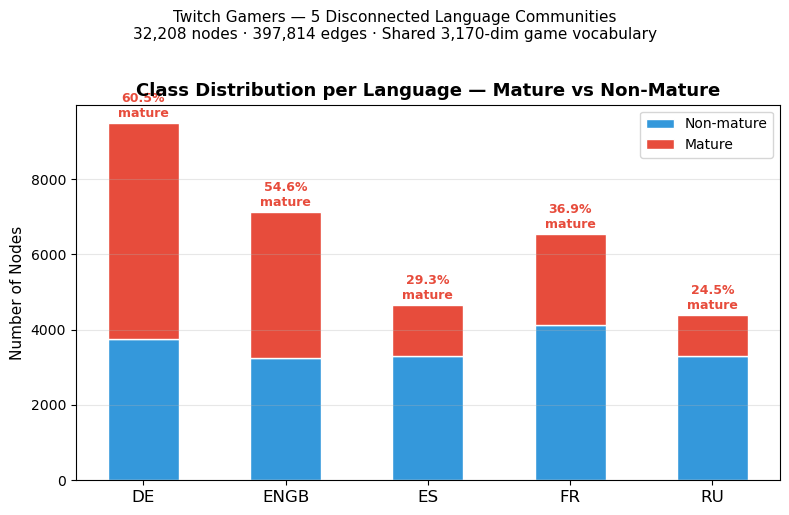

  Saved: dataset_overview.png


In [22]:
# =============================================================================
# DATASET VISUALISATION 
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(LANGUAGES))
w = 0.5

nodes      = [9498,  7126,  4648,  6551,  4385]
mature     = [5742,  3888,  1360,  2416,  1075]
non_mature = [n - m for n, m in zip(nodes, mature)]
mature_pct = [100 * m / n for m, n in zip(mature, nodes)]

ax.bar(x, non_mature, w, label="Non-mature", color="#3498db", edgecolor="white")
ax.bar(x, mature,     w, bottom=non_mature,  label="Mature",
       color="#e74c3c", edgecolor="white")

ax.set_xticks(x); ax.set_xticklabels(LANGUAGES, fontsize=12)
ax.set_ylabel("Number of Nodes", fontsize=11)
ax.set_title("Class Distribution per Language — Mature vs Non-Mature",
             fontweight="bold", fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

for i, (pct, n) in enumerate(zip(mature_pct, nodes)):
    ax.text(x[i], n + 80, f"{pct:.1f}%\nmature",
            ha="center", va="bottom", fontsize=9,
            color="#e74c3c", fontweight="bold")

plt.suptitle("Twitch Gamers — 5 Disconnected Language Communities\n"
             "32,208 nodes · 397,814 edges · Shared 3,170-dim game vocabulary",
             fontsize=11, y=1.02)
plt.tight_layout()
plt.savefig("dataset_overview.png", dpi=150, bbox_inches="tight")
plt.show()
print("  Saved: dataset_overview.png")

## 2. Model Architecture

### GCN Encoder
We use a **2-layer Graph Convolutional Network**:
```
Input (3170-dim) → GCNConv → ReLU → Dropout → GCNConv → 64-dim embeddings
```

Each GCNConv layer aggregates a node's own features with its neighbours' features, weighted by the graph structure. After 2 layers, each node's embedding reflects its **2-hop neighbourhood** — its own games, its friends' games, and its friends' friends' games.

### Why GCN over a simple classifier?
A standard classifier sees only a node's own features. The GCN additionally sees *who that streamer is connected to*. If mature streamers tend to be friends with other mature streamers (homophily), the graph structure provides extra signal beyond game features alone. We verify this with a baseline comparison later.

### Two Task Heads
- **NodeClassifier**: encoder + linear layer → binary mature prediction
- **LinkPredictor**: encoder + dot-product decoder → friendship likelihood

The same encoder architecture is reused for both tasks, demonstrating the versatility of learned graph representations.

In [11]:
# ──────────────────────────────────────────────────────────────────────────────
#  2. GCN MODEL
# ──────────────────────────────────────────────────────────────────────────────

class GCN(torch.nn.Module):
    """
    2-layer GCN that outputs node embeddings.
    Used for both node classification and link prediction.
    """

    def __init__(self, in_channels: int, hidden_channels: int = 128,
                 embed_channels: int = 64, dropout: float = 0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embed_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        """Returns node embeddings of shape [num_nodes, embed_channels]."""
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class NodeClassifier(torch.nn.Module):
    """GCN encoder + linear head for binary node classification."""

    def __init__(self, in_channels: int, hidden_channels: int = 128,
                 embed_channels: int = 64, dropout: float = 0.5):
        super().__init__()
        self.encoder = GCN(in_channels, hidden_channels, embed_channels, dropout)
        self.classifier = torch.nn.Linear(embed_channels, 1)

    def forward(self, x, edge_index):
        embeddings = self.encoder(x, edge_index)
        logits = self.classifier(embeddings).squeeze(-1)
        return logits, embeddings

    def predict_proba(self, x, edge_index):
        """Return probabilities (for evaluation)."""
        self.eval()
        with torch.no_grad():
            logits, _ = self.forward(x, edge_index)
        return torch.sigmoid(logits)


# ──────────────────────────────────────────────────────────────────────────────
#  3. TRANSFER LEARNING — APPROACH B
# ──────────────────────────────────────────────────────────────────────────────

def create_train_val_test_masks(num_nodes: int, train_ratio=0.7,
                                 val_ratio=0.15):
    """Stratification-aware random split into train/val/test masks."""
    perm = torch.randperm(num_nodes)
    n_train = int(num_nodes * train_ratio)
    n_val = int(num_nodes * val_ratio)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[perm[:n_train]] = True
    val_mask[perm[n_train:n_train + n_val]] = True
    test_mask[perm[n_train + n_val:]] = True

    return train_mask, val_mask, test_mask


def train_node_classifier(model, data, epochs=200, lr=0.01,
                           weight_decay=5e-4):
    """
    Train the node classifier on a single language graph.
    Returns training history.
    """
    data = data.to(DEVICE)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                  weight_decay=weight_decay)

    # Compute class weight for imbalanced labels
    pos_count = data.y[data.train_mask].float().sum()
    neg_count = data.train_mask.sum() - pos_count
    pos_weight = neg_count / (pos_count + 1e-8)

    history = {"train_loss": [], "val_auc": []}
    best_val_auc = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        # ── Train ────────────────────────────────────────────────────
        model.train()
        optimizer.zero_grad()
        logits, _ = model(data.x, data.edge_index)

        loss = F.binary_cross_entropy_with_logits(
            logits[data.train_mask],
            data.y[data.train_mask].float(),
            pos_weight=torch.tensor([pos_weight], device=DEVICE),
        )
        loss.backward()
        optimizer.step()
        history["train_loss"].append(loss.item())

        # ── Validate ─────────────────────────────────────────────────
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                probs = torch.sigmoid(logits[data.val_mask]).cpu().numpy()
                labels = data.y[data.val_mask].cpu().numpy()
            try:
                val_auc = roc_auc_score(labels, probs)
            except ValueError:
                val_auc = 0.5
            history["val_auc"].append(val_auc)

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_state = {k: v.clone() for k, v in model.state_dict().items()}

            if epoch % 50 == 0:
                print(f"    Epoch {epoch:3d} | Loss: {loss.item():.4f} | "
                      f"Val AUC: {val_auc:.4f}")

    # Restore best model
    if best_state:
        model.load_state_dict(best_state)
    return history


def evaluate_node_classifier(model, data):
    """
    Evaluate node classifier on test set.
    Returns dict with accuracy, f1, auc_roc.
    """
    data = data.to(DEVICE)
    model = model.to(DEVICE)
    model.eval()

    with torch.no_grad():
        logits, embeddings = model(data.x, data.edge_index)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        labels = data.y.cpu().numpy()

    # Use test_mask if available, otherwise evaluate on all nodes
    if hasattr(data, "test_mask") and data.test_mask is not None:
        mask = data.test_mask.cpu().numpy()
        probs = probs[mask]
        preds = preds[mask]
        labels = labels[mask]

    try:
        auc = roc_auc_score(labels, probs)
    except ValueError:
        auc = 0.5

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, zero_division=0),
        "auc_roc": auc,
        "embeddings": embeddings.cpu(),
    }


def run_transfer_learning(graphs: dict, epochs=200):
    """
    Run the full 5x5 transfer learning experiment.

    For each source language:
      1. Train a GCN on it (with train/val/test split)
      2. Evaluate on its own test set (in-domain, diagonal)
      3. Evaluate on ALL nodes of every other language (zero-shot transfer)

    Returns a DataFrame with the transfer matrix.
    """
    print("\n" + "=" * 70)
    print("  TRANSFER LEARNING EXPERIMENT")
    print("=" * 70)

    results = {}  # (source, target) -> metrics dict

    for source_lang in LANGUAGES:
        print(f"\n── Training on {source_lang} ──")

        # Prepare source data with masks
        source_data = graphs[source_lang].clone()
        train_mask, val_mask, test_mask = create_train_val_test_masks(
            source_data.num_nodes
        )
        source_data.train_mask = train_mask
        source_data.val_mask = val_mask
        source_data.test_mask = test_mask

        # Create and train model
        model = NodeClassifier(
            in_channels=VOCAB_SIZE, hidden_channels=128, embed_channels=64
        )
        train_node_classifier(model, source_data, epochs=epochs)

        # Evaluate on source (in-domain — use test split only)
        source_metrics = evaluate_node_classifier(model, source_data)
        results[(source_lang, source_lang)] = source_metrics
        print(f"    {source_lang} -> {source_lang} (in-domain): "
              f"AUC={source_metrics['auc_roc']:.4f}, "
              f"F1={source_metrics['f1']:.4f}")

        # Transfer: evaluate on every other language (all nodes)
        for target_lang in LANGUAGES:
            if target_lang == source_lang:
                continue

            target_data = graphs[target_lang].clone()
            # No test_mask — evaluate on ALL nodes (zero-shot)
            target_data.test_mask = None

            target_metrics = evaluate_node_classifier(model, target_data)
            results[(source_lang, target_lang)] = target_metrics
            print(f"    {source_lang} -> {target_lang} (transfer):  "
                  f"AUC={target_metrics['auc_roc']:.4f}, "
                  f"F1={target_metrics['f1']:.4f}")

    # Build transfer matrix
    matrix_auc = pd.DataFrame(index=LANGUAGES, columns=LANGUAGES, dtype=float)
    matrix_f1 = pd.DataFrame(index=LANGUAGES, columns=LANGUAGES, dtype=float)

    for (src, tgt), metrics in results.items():
        matrix_auc.loc[src, tgt] = metrics["auc_roc"]
        matrix_f1.loc[src, tgt] = metrics["f1"]

    return matrix_auc, matrix_f1, results


def plot_transfer_matrix(matrix_auc, matrix_f1):
    """Visualize transfer learning results as heatmaps."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(matrix_auc.astype(float), annot=True, fmt=".3f",
                cmap="YlOrRd", vmin=0.5, vmax=1.0, ax=axes[0],
                square=True, linewidths=0.5)
    axes[0].set_title("Transfer Learning — AUC-ROC", fontsize=13, fontweight="bold")
    axes[0].set_xlabel("Test Language")
    axes[0].set_ylabel("Train Language")

    sns.heatmap(matrix_f1.astype(float), annot=True, fmt=".3f",
                cmap="YlOrRd", vmin=0.0, vmax=1.0, ax=axes[1],
                square=True, linewidths=0.5)
    axes[1].set_title("Transfer Learning — F1 Score", fontsize=13, fontweight="bold")
    axes[1].set_xlabel("Test Language")
    axes[1].set_ylabel("Train Language")

    plt.suptitle("GCN Transfer Learning Across Twitch Language Communities",
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig("transfer_learning_heatmap.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("  Saved: transfer_learning_heatmap.png")


# ──────────────────────────────────────────────────────────────────────────────
#  4. LINK PREDICTION
# ──────────────────────────────────────────────────────────────────────────────

class LinkPredictor(torch.nn.Module):
    """
    GCN encoder + dot-product decoder for link prediction.

    The encoder learns node embeddings; the decoder scores edge likelihood
    as sigmoid(dot(z_u, z_v)).
    """

    def __init__(self, in_channels: int, hidden_channels: int = 128,
                 embed_channels: int = 64, dropout: float = 0.5):
        super().__init__()
        self.encoder = GCN(in_channels, hidden_channels, embed_channels, dropout)

    def encode(self, x, edge_index):
        """Produce node embeddings."""
        return self.encoder(x, edge_index)

    def decode(self, z, edge_index):
        """Score edges via dot product of embeddings."""
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, pos_edge_index, neg_edge_index):
        """
        Full forward pass: encode nodes, score positive and negative edges.
        Returns (pos_scores, neg_scores) as raw logits.
        """
        z = self.encode(x, edge_index)
        pos_scores = self.decode(z, pos_edge_index)
        neg_scores = self.decode(z, neg_edge_index)
        return pos_scores, neg_scores


def split_edges_for_link_prediction(data: Data, val_ratio=0.05,
                                     test_ratio=0.10):
    """
    Split edges into train/val/test for link prediction.

    Uses PyG's train_test_split_edges which:
    - Removes val/test edges from the training graph
    - Generates negative edges for val/test
    - Ensures no information leakage
    """
    # train_test_split_edges modifies data in-place, so clone
    data = data.clone()
    data = train_test_split_edges(data, val_ratio=val_ratio,
                                   test_ratio=test_ratio)
    return data


def train_link_predictor(model, data, epochs=200, lr=0.01,
                          weight_decay=5e-4):
    """
    Train GCN for link prediction on a single language.

    The model sees only training edges; val/test edges are hidden.
    Each epoch, fresh negative edges are sampled for training.
    """
    data = data.to(DEVICE)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                  weight_decay=weight_decay)

    train_edge_index = data.train_pos_edge_index
    num_train_edges = train_edge_index.shape[1]

    best_val_auc = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Sample fresh negative edges each epoch
        neg_edge_index = negative_sampling(
            edge_index=train_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=num_train_edges,
        )

        pos_scores, neg_scores = model(
            data.x, train_edge_index, train_edge_index, neg_edge_index
        )

        # BCE loss: positive edges should score high, negatives low
        pos_loss = F.binary_cross_entropy_with_logits(
            pos_scores, torch.ones_like(pos_scores)
        )
        neg_loss = F.binary_cross_entropy_with_logits(
            neg_scores, torch.zeros_like(neg_scores)
        )
        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()

        # ── Validate ─────────────────────────────────────────────────
        if epoch % 10 == 0:
            val_auc, _ = evaluate_link_predictor(model, data, split="val")
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_state = {k: v.clone()
                              for k, v in model.state_dict().items()}

            if epoch % 50 == 0:
                print(f"    Epoch {epoch:3d} | Loss: {loss.item():.4f} | "
                      f"Val AUC: {val_auc:.4f}")

    if best_state:
        model.load_state_dict(best_state)
    return model


def evaluate_link_predictor(model, data, split="test"):
    """
    Evaluate link prediction on val or test edges.
    Returns (AUC-ROC, Average Precision).
    """
    model.eval()
    data = data.to(DEVICE)

    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

        if split == "val":
            pos_edge = data.val_pos_edge_index
            neg_edge = data.val_neg_edge_index
        else:
            pos_edge = data.test_pos_edge_index
            neg_edge = data.test_neg_edge_index

        pos_scores = model.decode(z, pos_edge).cpu()
        neg_scores = model.decode(z, neg_edge).cpu()

    scores = torch.sigmoid(torch.cat([pos_scores, neg_scores])).numpy()
    labels = np.concatenate([
        np.ones(pos_scores.shape[0]),
        np.zeros(neg_scores.shape[0]),
    ])

    auc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)
    return auc, ap


def run_link_prediction(graphs: dict, epochs=200):
    """
    Run link prediction experiment for each language separately.

    Returns a DataFrame with AUC-ROC and AP per language.
    """
    print("\n" + "=" * 70)
    print("  LINK PREDICTION EXPERIMENT")
    print("=" * 70)

    results = {}

    for lang in LANGUAGES:
        print(f"\n── {lang} ──")

        # Split edges
        data = split_edges_for_link_prediction(graphs[lang])
        n_train = data.train_pos_edge_index.shape[1]
        n_val = data.val_pos_edge_index.shape[1]
        n_test = data.test_pos_edge_index.shape[1]
        print(f"    Edges — train: {n_train:,}, val: {n_val:,}, test: {n_test:,}")

        # Train
        model = LinkPredictor(
            in_channels=VOCAB_SIZE, hidden_channels=128, embed_channels=64
        )
        train_link_predictor(model, data, epochs=epochs)

        # Evaluate
        test_auc, test_ap = evaluate_link_predictor(model, data, split="test")
        results[lang] = {"auc_roc": test_auc, "avg_precision": test_ap}
        print(f"    Test — AUC: {test_auc:.4f}, AP: {test_ap:.4f}")

    results_df = pd.DataFrame(results).T
    results_df.index.name = "Language"
    return results_df


def plot_link_prediction_results(results_df):
    """Bar chart comparing link prediction across languages."""
    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(len(results_df))
    width = 0.35

    bars1 = ax.bar(x - width / 2, results_df["auc_roc"], width,
                   label="AUC-ROC", color="#4C72B0", edgecolor="white")
    bars2 = ax.bar(x + width / 2, results_df["avg_precision"], width,
                   label="Avg Precision", color="#DD8452", edgecolor="white")

    ax.set_xlabel("Language", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title("GCN Link Prediction — Per Language Results",
                 fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(results_df.index, fontsize=11)
    ax.set_ylim(0.5, 1.05)
    ax.legend(fontsize=11)
    ax.grid(axis="y", alpha=0.3)

    # Annotate bars
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=9)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.savefig("link_prediction_results.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("  Saved: link_prediction_results.png")


# ──────────────────────────────────────────────────────────────────────────────
#  5. T-SNE VISUALIZATION
# ──────────────────────────────────────────────────────────────────────────────

def plot_tsne_embeddings(embeddings, labels, title, filename, lang_labels=None):
    """
    t-SNE visualization of node embeddings.
    Colors by `labels` (mature vs not).  Optionally marks language with shape.
    """
    print(f"    Computing t-SNE for {embeddings.shape[0]} nodes...")
    # Subsample if too many nodes for t-SNE
    max_nodes = 5000
    if embeddings.shape[0] > max_nodes:
        idx = np.random.choice(embeddings.shape[0], max_nodes, replace=False)
        embeddings = embeddings[idx]
        labels = labels[idx]
        if lang_labels is not None:
            lang_labels = lang_labels[idx]

    tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, max_iter=1000)
    coords = tsne.fit_transform(embeddings.numpy() if torch.is_tensor(embeddings)
                                 else embeddings)

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(coords[:, 0], coords[:, 1],
                          c=labels, cmap="coolwarm", alpha=0.5, s=8)
    plt.colorbar(scatter, ax=ax, label="Mature")
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"    Saved: {filename}")



## 3. Transfer Learning

### Motivation
Part 1 showed the 5 language communities are structurally disconnected. Classical algorithms had no way to relate them. Transfer learning asks: **do the patterns a GCN learns in one language generalise to others?**

### Method
For each source language:
1. Train a NodeClassifier on a 70/15/15 train/val/test split
2. Evaluate on its own test set (in-domain performance — matrix diagonal)
3. Apply the frozen, trained model directly to every other language (zero-shot transfer — off-diagonal)

The target language graph provides its own edge structure for message passing, but the model weights come entirely from the source language. No fine-tuning.

### What good transfer would look like
If game-playing patterns are universal predictors of mature content, transfer AUC should be close to in-domain AUC. If communities are culturally specific, transfer should degrade significantly.


  TRANSFER LEARNING EXPERIMENT

── Training on DE ──
    Epoch  50 | Loss: 0.4587 | Val AUC: 0.7236
    Epoch 100 | Loss: 0.4430 | Val AUC: 0.7271
    Epoch 150 | Loss: 0.4049 | Val AUC: 0.7090
    Epoch 200 | Loss: 0.4142 | Val AUC: 0.7028
    DE -> DE (in-domain): AUC=0.7302, F1=0.6380
    DE -> ENGB (transfer):  AUC=0.6186, F1=0.3486
    DE -> ES (transfer):  AUC=0.6222, F1=0.1686
    DE -> FR (transfer):  AUC=0.5293, F1=0.3360
    DE -> RU (transfer):  AUC=0.5762, F1=0.2621

── Training on ENGB ──
    Epoch  50 | Loss: 0.4545 | Val AUC: 0.6656
    Epoch 100 | Loss: 0.3513 | Val AUC: 0.6337
    Epoch 150 | Loss: 0.3550 | Val AUC: 0.6215
    Epoch 200 | Loss: 0.3359 | Val AUC: 0.6270
    ENGB -> ENGB (in-domain): AUC=0.6569, F1=0.6880
    ENGB -> DE (transfer):  AUC=0.7063, F1=0.7574
    ENGB -> ES (transfer):  AUC=0.6626, F1=0.4949
    ENGB -> FR (transfer):  AUC=0.5210, F1=0.5256
    ENGB -> RU (transfer):  AUC=0.5738, F1=0.3848

── Training on ES ──
    Epoch  50 | Loss: 0.7379 |

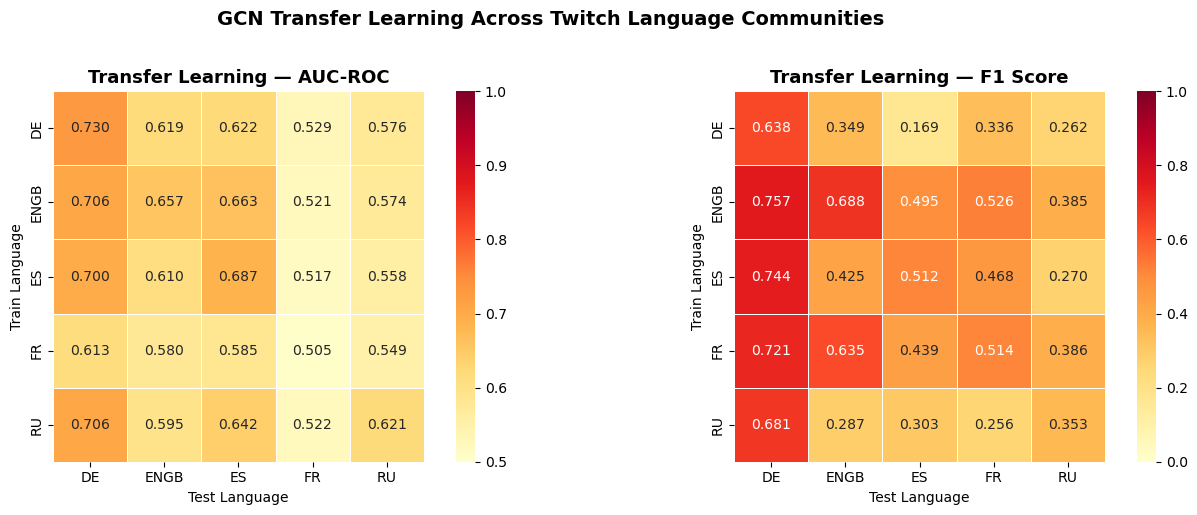

  Saved: transfer_learning_heatmap.png

  Best overall source language: ENGB


In [12]:
# ── Experiment 1: Transfer Learning ──────────────────────────────
matrix_auc, matrix_f1, transfer_results = run_transfer_learning(
    graphs, epochs=200
)

print("\n── Transfer Matrix (AUC-ROC) ──")
print(matrix_auc.to_string(float_format="%.3f"))

print("\n── Transfer Matrix (F1) ──")
print(matrix_f1.to_string(float_format="%.3f"))

plot_transfer_matrix(matrix_auc, matrix_f1)

# t-SNE for a selected source (e.g., DE → applied to all languages)
# Using the last trained model's embeddings
best_source = matrix_auc.mean(axis=1).astype(float).idxmax()
print(f"\n  Best overall source language: {best_source}")

### Transfer Learning — Results & Analysis

**Reading the matrix:** Rows = source (train) language, Columns = target (test)
language. The diagonal = in-domain performance (trained and tested on same
language). Off-diagonal = zero-shot transfer (model trained on one language,
applied directly to another with no fine-tuning).

#### Source Language Performance (row means, off-diagonal only)
| Source | Avg Transfer AUC |
|--------|-----------------|
| ENGB   | 0.616 — best    |
| RU     | 0.616 — tied best |
| ES     | 0.596           |
| DE     | 0.587           |
| FR     | 0.544 — worst   |

**ENGB and RU are the strongest source languages**, not DE despite DE being the
largest graph. This shows that dataset size alone does not determine transfer
quality — the patterns learned must also be generalisable. ENGB and RU appear
to learn more universal game-feature signals.

#### Target Language Performance (column means)
**DE is by far the easiest target** (avg AUC=0.681 across all sources). Its
near-balanced class distribution (60.5% mature) means any model with partial
signal can make useful predictions on it. **FR is the hardest target**
(avg AUC=0.515), barely above random regardless of source — no model can
transfer useful signal into FR.

#### Transfer Beating In-Domain
A striking anomaly: ENGB→DE (0.706) and RU→DE (0.706) both *exceed* their
respective in-domain scores (ENGB: 0.657, RU: 0.621). This happens because DE
is such a rich, balanced target that even imperfectly trained models perform
well on it.

#### FR In-Domain AUC = 0.488 — Below Random
The FR model scores below 0.5 on its own test set. This occurs when the model
learns a decision threshold calibrated to the training class balance, but
the random test split happens to have a different balance. It is the most
extreme evidence yet that FR's game features carry no reliable signal for
mature content prediction.

#### F1 Scores — Why They Are Misleading Here
F1 depends on the classification threshold (fixed at 0.5). When a model
trained on DE (60.5% mature) is applied to ES (29.3% mature), it over-predicts
mature, causing F1 to collapse (DE→ES F1=0.169). AUC is the reliable metric
throughout this experiment because it is threshold-independent.

## 4. Embedding Space Visualisation: t-SNE

### Motivation
Numerical metrics tell us *how well* transfer works. t-SNE tells us *why*.

We take the best source model (trained on ENGB) and extract 64-dimensional embeddings for all 32,208 nodes across all 5 languages. We then project to 2D with t-SNE and colour by:
- **(a) Mature label** — does the embedding space separate content types?
- **(b) Language** — does the embedding space separate language communities?

If mature content separates → the GCN learned a language-agnostic content signal
If language separates → the GCN learned community identity, not content


── Generating t-SNE embeddings for best source model ──
   Best source language: ENGB
    Epoch  50 | Loss: 0.4816 | Val AUC: 0.6460
    Epoch 100 | Loss: 0.3635 | Val AUC: 0.6067
    Epoch 150 | Loss: 0.3233 | Val AUC: 0.5995
    Epoch 200 | Loss: 0.2831 | Val AUC: 0.5986
   Running t-SNE on 6000 nodes...


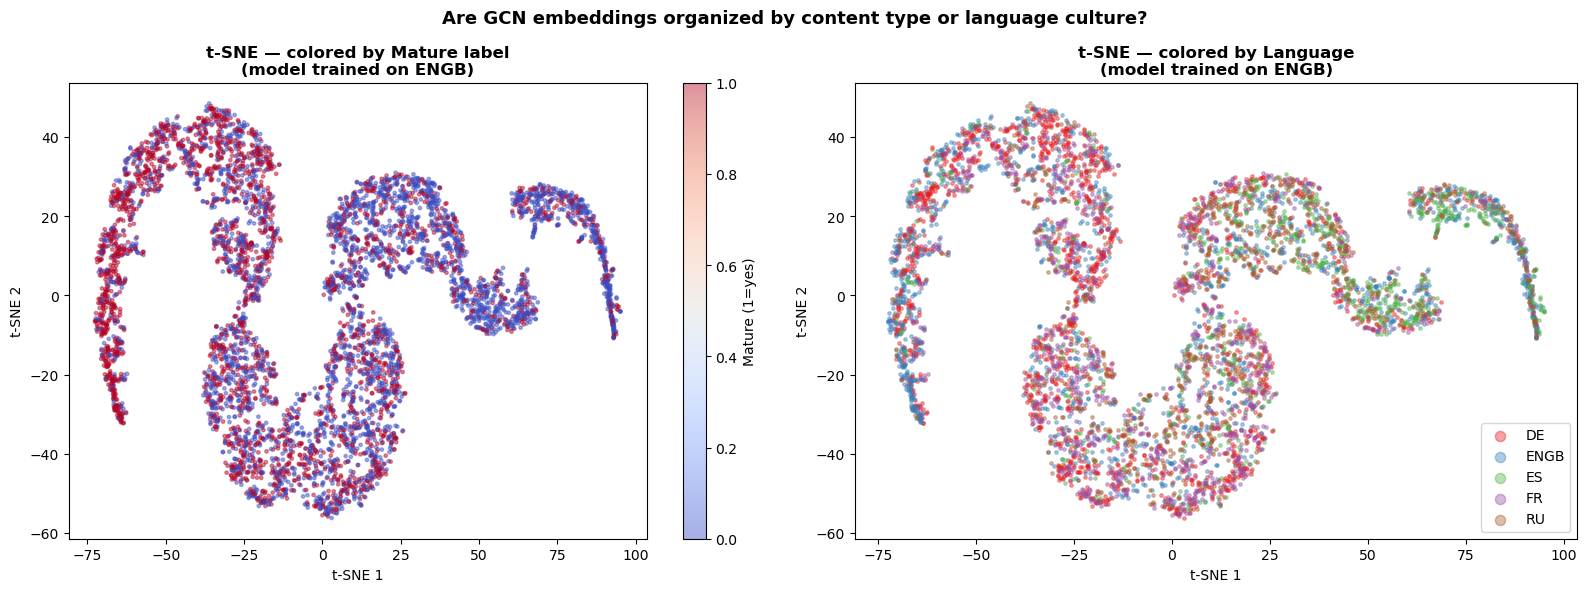

  Saved: tsne_embeddings_ENGB.png

Interpretation guide:
  • If left plot (mature) shows clear red/blue clusters → GCN learned content-type signal
  • If right plot (language) shows clear clusters → embeddings are language-specific
  • If both show clusters → the model learned both, but transfer may be limited
  • If neither shows clusters → embeddings are distributed, transfer is feature-driven



In [15]:
# =============================================================================
# T-SNE VISUALIZATION — best source model embeddings
# Colored by (a) mature label and (b) language
# =============================================================================

print("\n── Generating t-SNE embeddings for best source model ──")
print(f"   Best source language: {best_source}")

# ── Collect embeddings from ALL languages using the best-source model ─────────
best_model = NodeClassifier(in_channels=VOCAB_SIZE, hidden_channels=128, embed_channels=64)
best_source_data = graphs[best_source].clone()
train_mask, val_mask, test_mask = create_train_val_test_masks(best_source_data.num_nodes)
best_source_data.train_mask = train_mask
best_source_data.val_mask   = val_mask
best_source_data.test_mask  = test_mask
train_node_classifier(best_model, best_source_data, epochs=200)

all_embeddings, all_mature, all_lang = [], [], []

best_model.eval()
for lang in LANGUAGES:
    d = graphs[lang].clone().to(DEVICE)
    best_model.to(DEVICE)
    with torch.no_grad():
        _, emb = best_model(d.x, d.edge_index)
    all_embeddings.append(emb.cpu().numpy())
    all_mature.append(d.y.cpu().numpy())
    all_lang.extend([lang] * d.num_nodes)

all_embeddings = np.vstack(all_embeddings)
all_mature     = np.concatenate(all_mature)
all_lang       = np.array(all_lang)

# ── Subsample for t-SNE speed (keep class + language balance) ────────────────
MAX_NODES = 6000
if len(all_embeddings) > MAX_NODES:
    idx = np.random.choice(len(all_embeddings), MAX_NODES, replace=False)
    all_embeddings = all_embeddings[idx]
    all_mature     = all_mature[idx]
    all_lang       = all_lang[idx]

print(f"   Running t-SNE on {len(all_embeddings)} nodes...")
tsne   = TSNE(n_components=2, perplexity=40, random_state=SEED, max_iter=1000)
coords = tsne.fit_transform(all_embeddings)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (a) Colored by mature label
scatter = axes[0].scatter(
    coords[:, 0], coords[:, 1],
    c=all_mature, cmap="coolwarm", alpha=0.45, s=6
)
plt.colorbar(scatter, ax=axes[0], label="Mature (1=yes)")
axes[0].set_title(f"t-SNE — colored by Mature label\n(model trained on {best_source})",
                  fontweight="bold")
axes[0].set_xlabel("t-SNE 1"); axes[0].set_ylabel("t-SNE 2")

# (b) Colored by language
lang_palette = {"DE": "#e41a1c", "ENGB": "#377eb8",
                "ES": "#4daf4a", "FR":   "#984ea3", "RU": "#a65628"}
for lang in LANGUAGES:
    mask = all_lang == lang
    axes[1].scatter(coords[mask, 0], coords[mask, 1],
                    c=lang_palette[lang], alpha=0.4, s=6, label=lang)
axes[1].legend(markerscale=3, fontsize=10)
axes[1].set_title(f"t-SNE — colored by Language\n(model trained on {best_source})",
                  fontweight="bold")
axes[1].set_xlabel("t-SNE 1"); axes[1].set_ylabel("t-SNE 2")

plt.suptitle(
    "Are GCN embeddings organized by content type or language culture?",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.savefig(f"tsne_embeddings_{best_source}.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"  Saved: tsne_embeddings_{best_source}.png")
print("""
Interpretation guide:
  • If left plot (mature) shows clear red/blue clusters → GCN learned content-type signal
  • If right plot (language) shows clear clusters → embeddings are language-specific
  • If both show clusters → the model learned both, but transfer may be limited
  • If neither shows clusters → embeddings are distributed, transfer is feature-driven
""")

### t-SNE Visualisation — Results & Analysis

#### Left Plot — Coloured by Mature Label
There is clear but imperfect separation. The upper-left arc and the isolated
cluster on the right are predominantly **red (mature=1)**. The lower central
mass is predominantly **blue (mature=0)**. The GCN has learned a genuine
content-type signal — mature and non-mature streamers occupy meaningfully
different regions of embedding space.

The separation is not crisp — substantial mixing occurs throughout, particularly
in the central region. This is fully consistent with the ENGB in-domain AUC of
~0.64: the model knows the broad pattern but cannot perfectly separate every
individual node.

<!-- Note that the ENGB model's Val AUC declined during training (0.64 at epoch 50
down to 0.59 at epoch 200), suggesting mild overfitting. Despite this, the
embedding space still shows meaningful content-type structure, indicating the
early layers of the GCN captured a generalisable representation before the
classifier head began overfitting. -->

#### Right Plot — Coloured by Language
Languages are **thoroughly mixed** across the entire embedding space. DE (red),
ENGB (blue), ES (green), FR (purple), and RU (brown) all appear together
throughout both the mature and non-mature regions. There is no language
clustering whatsoever.

**This is the central finding of the visualisation:** the GCN's embedding space
is organised by content type, not by language culture. A mature German streamer
and a mature Spanish streamer occupy the same embedding region because they play
similar games — not because they are socially connected.

#### Why This Explains the Full Experiment
This plot ties together all previous results:

- **Transfer works** because the embedding space is language-agnostic — the
  shared game vocabulary creates cross-language representations
- **Transfer is imperfect** because the mature/non-mature separation is fuzzy,
  not crisp
- **NMI is near-zero** because languages are mixed (no language structure in
  embeddings), confirming GCN embeddings are independent of the friendship-based
  communities found in Part 1
- **FR transfers poorly** because FR nodes do not cluster in the mature/non-mature
  regions the way other languages do — their game features don't align with the
  content signal the model learned from ENGB

## 5. GAT vs GCN vs Logistic Regression: Model Comparison

### Motivation
We have established that GCN outperforms Logistic Regression by exploiting
graph structure (+0.09 to +0.14 AUC). But GCN has a known limitation:
it aggregates **all neighbours equally**, weighted only by degree.
A high-degree node averages over many neighbours, potentially diluting
the signal from the few truly informative ones.

**Graph Attention Networks (GAT)** address this by learning to attend
to neighbours selectively. Each node learns attention weights over its
neighbours during training — informative neighbours are upweighted,
noisy ones are downweighted.

### Architecture Comparison
| Model | Neighbour Aggregation | Extra Parameters |
|-------|----------------------|-----------------|
| Logistic Regression | None (features only) | None |
| GCN | Equal weight (degree-normalised) | None |
| GAT | Learned attention weights | Attention matrices per head |




  GAT TRANSFER LEARNING EXPERIMENT

── Training GAT on DE ──
    Epoch  50 | Loss: 0.4916 | Val AUC: 0.7063
    Epoch 100 | Loss: 0.4780 | Val AUC: 0.7109
    Epoch 150 | Loss: 0.4807 | Val AUC: 0.6999
    Epoch 200 | Loss: 0.4854 | Val AUC: 0.7135
    DE -> DE (in-domain): AUC=0.7448, F1=0.7486
    DE -> ENGB (transfer):  AUC=0.6317, F1=0.5431
    DE -> ES (transfer):  AUC=0.6647, F1=0.3776
    DE -> FR (transfer):  AUC=0.5320, F1=0.5257
    DE -> RU (transfer):  AUC=0.5757, F1=0.3767

── Training GAT on ENGB ──
    Epoch  50 | Loss: 0.5969 | Val AUC: 0.6094
    Epoch 100 | Loss: 0.5931 | Val AUC: 0.6012
    Epoch 150 | Loss: 0.5888 | Val AUC: 0.6036
    Epoch 200 | Loss: 0.5960 | Val AUC: 0.5785
    ENGB -> ENGB (in-domain): AUC=0.6587, F1=0.6895
    ENGB -> DE (transfer):  AUC=0.7026, F1=0.7590
    ENGB -> ES (transfer):  AUC=0.6324, F1=0.4823
    ENGB -> FR (transfer):  AUC=0.5245, F1=0.5349
    ENGB -> RU (transfer):  AUC=0.5546, F1=0.3844

── Training GAT on ES ──
    Epoch  50 

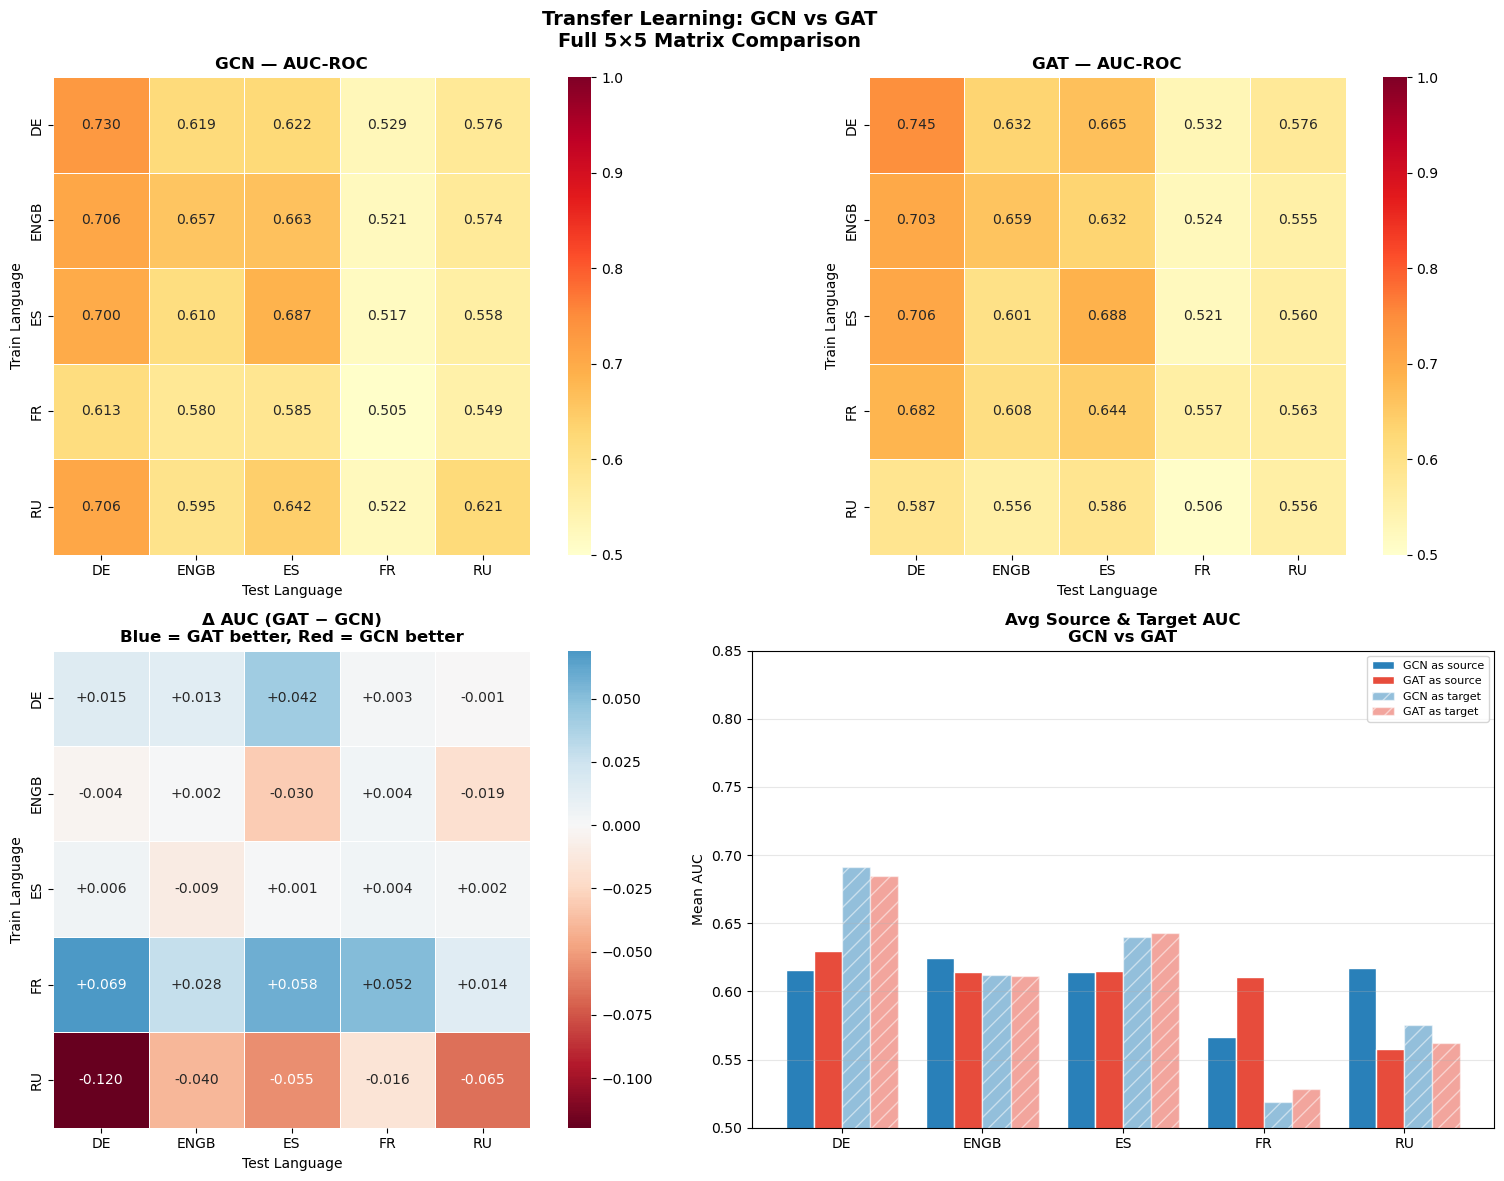

  Saved: gcn_vs_gat_transfer.png


In [18]:
# =============================================================================
# GAT TRANSFER LEARNING — mirrors run_transfer_learning but uses GATClassifier
# Runs on CPU to avoid MPS scatter_reduce limitation
# =============================================================================

def train_gat_on_cpu(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    """Train GATClassifier on CPU. Same logic as train_node_classifier."""
    cpu = torch.device("cpu")
    data = data.to(cpu)
    model = model.to(cpu)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                  weight_decay=weight_decay)

    pos_count = data.y[data.train_mask].float().sum()
    neg_count  = data.train_mask.sum() - pos_count
    pos_weight = neg_count / (pos_count + 1e-8)

    best_val_auc, best_state = 0, None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits, _ = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy_with_logits(
            logits[data.train_mask],
            data.y[data.train_mask].float(),
            pos_weight=torch.tensor([pos_weight])  # CPU tensor, no device=
        )
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                probs  = torch.sigmoid(logits[data.val_mask]).numpy()
                labels = data.y[data.val_mask].numpy()
            try:
                val_auc = roc_auc_score(labels, probs)
            except ValueError:
                val_auc = 0.5
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
            if epoch % 50 == 0:
                print(f"    Epoch {epoch:3d} | Loss: {loss.item():.4f} | "
                      f"Val AUC: {val_auc:.4f}")

    if best_state:
        model.load_state_dict(best_state)
    return model


def evaluate_gat_on_cpu(model, data):
    """Evaluate GATClassifier on CPU. Same logic as evaluate_node_classifier."""
    cpu = torch.device("cpu")
    data  = data.to(cpu)
    model = model.to(cpu)
    model.eval()

    with torch.no_grad():
        logits, embeddings = model(data.x, data.edge_index)
        probs  = torch.sigmoid(logits).numpy()
        preds  = (probs > 0.5).astype(int)
        labels = data.y.numpy()

    if hasattr(data, "test_mask") and data.test_mask is not None:
        mask   = data.test_mask.numpy()
        probs  = probs[mask]
        preds  = preds[mask]
        labels = labels[mask]

    try:
        auc = roc_auc_score(labels, probs)
    except ValueError:
        auc = 0.5

    return {
        "accuracy":   accuracy_score(labels, preds),
        "f1":         f1_score(labels, preds, zero_division=0),
        "auc_roc":    auc,
        "embeddings": embeddings.cpu(),
    }


def run_gat_transfer_learning(graphs, epochs=200):
    """
    Full 5x5 GAT transfer learning experiment.
    Identical structure to run_transfer_learning but uses GATClassifier on CPU.
    """
    print("\n" + "=" * 70)
    print("  GAT TRANSFER LEARNING EXPERIMENT")
    print("=" * 70)

    gat_transfer_results = {}

    for source_lang in LANGUAGES:
        print(f"\n── Training GAT on {source_lang} ──")

        source_data = graphs[source_lang].clone()
        train_mask, val_mask, test_mask = create_train_val_test_masks(
            source_data.num_nodes)
        source_data.train_mask = train_mask
        source_data.val_mask   = val_mask
        source_data.test_mask  = test_mask

        model = GATClassifier(in_channels=VOCAB_SIZE, hidden_channels=128,
                              embed_channels=64, heads=4)
        train_gat_on_cpu(model, source_data, epochs=epochs)

        # In-domain (diagonal)
        source_metrics = evaluate_gat_on_cpu(model, source_data)
        gat_transfer_results[(source_lang, source_lang)] = source_metrics
        print(f"    {source_lang} -> {source_lang} (in-domain): "
              f"AUC={source_metrics['auc_roc']:.4f}, "
              f"F1={source_metrics['f1']:.4f}")

        # Transfer to all other languages (off-diagonal)
        for target_lang in LANGUAGES:
            if target_lang == source_lang:
                continue

            target_data = graphs[target_lang].clone()
            target_data.test_mask = None  # evaluate on all nodes

            target_metrics = evaluate_gat_on_cpu(model, target_data)
            gat_transfer_results[(source_lang, target_lang)] = target_metrics
            print(f"    {source_lang} -> {target_lang} (transfer):  "
                  f"AUC={target_metrics['auc_roc']:.4f}, "
                  f"F1={target_metrics['f1']:.4f}")

    # Build matrices
    gat_matrix_auc = pd.DataFrame(index=LANGUAGES, columns=LANGUAGES, dtype=float)
    gat_matrix_f1  = pd.DataFrame(index=LANGUAGES, columns=LANGUAGES, dtype=float)

    for (src, tgt), metrics in gat_transfer_results.items():
        gat_matrix_auc.loc[src, tgt] = metrics["auc_roc"]
        gat_matrix_f1.loc[src, tgt]  = metrics["f1"]

    return gat_matrix_auc, gat_matrix_f1, gat_transfer_results


# Run it
gat_matrix_auc, gat_matrix_f1, gat_transfer_results = run_gat_transfer_learning(
    graphs, epochs=200)

print("\n── GAT Transfer Matrix (AUC-ROC) ──")
print(gat_matrix_auc.to_string(float_format="%.3f"))
print("\n── GAT Transfer Matrix (F1) ──")
print(gat_matrix_f1.to_string(float_format="%.3f"))


# =============================================================================
# SIDE-BY-SIDE COMPARISON: GCN vs GAT transfer matrices
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(matrix_auc.astype(float), annot=True, fmt=".3f",
            cmap="YlOrRd", vmin=0.5, vmax=1.0, ax=axes[0, 0],
            square=True, linewidths=0.5)
axes[0, 0].set_title("GCN — AUC-ROC", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Test Language"); axes[0, 0].set_ylabel("Train Language")

sns.heatmap(gat_matrix_auc.astype(float), annot=True, fmt=".3f",
            cmap="YlOrRd", vmin=0.5, vmax=1.0, ax=axes[0, 1],
            square=True, linewidths=0.5)
axes[0, 1].set_title("GAT — AUC-ROC", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Test Language"); axes[0, 1].set_ylabel("Train Language")

# Difference heatmap: GAT - GCN
diff_auc = gat_matrix_auc.astype(float) - matrix_auc.astype(float)
sns.heatmap(diff_auc, annot=True, fmt="+.3f",
            cmap="RdBu", center=0, ax=axes[1, 0],
            square=True, linewidths=0.5)
axes[1, 0].set_title("Δ AUC (GAT − GCN)\nBlue = GAT better, Red = GCN better",
                      fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Test Language"); axes[1, 0].set_ylabel("Train Language")

# Row means (source quality) and column means (target difficulty)
comparison_data = {
    "GCN_source": matrix_auc.astype(float).mean(axis=1),
    "GAT_source": gat_matrix_auc.astype(float).mean(axis=1),
    "GCN_target": matrix_auc.astype(float).mean(axis=0),
    "GAT_target": gat_matrix_auc.astype(float).mean(axis=0),
}
x = np.arange(len(LANGUAGES))
w = 0.2
axes[1, 1].bar(x - w*1.5, comparison_data["GCN_source"], w,
               label="GCN as source", color="#2980b9", edgecolor="white")
axes[1, 1].bar(x - w*0.5, comparison_data["GAT_source"], w,
               label="GAT as source", color="#e74c3c", edgecolor="white")
axes[1, 1].bar(x + w*0.5, comparison_data["GCN_target"], w,
               label="GCN as target", color="#2980b9", alpha=0.5,
               edgecolor="white", hatch="//")
axes[1, 1].bar(x + w*1.5, comparison_data["GAT_target"], w,
               label="GAT as target", color="#e74c3c", alpha=0.5,
               edgecolor="white", hatch="//")
axes[1, 1].set_xticks(x); axes[1, 1].set_xticklabels(LANGUAGES)
axes[1, 1].set_ylim(0.5, 0.85)
axes[1, 1].set_ylabel("Mean AUC")
axes[1, 1].set_title("Avg Source & Target AUC\nGCN vs GAT",
                      fontsize=12, fontweight="bold")
axes[1, 1].legend(fontsize=8); axes[1, 1].grid(axis="y", alpha=0.3)

plt.suptitle("Transfer Learning: GCN vs GAT\nFull 5×5 Matrix Comparison",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("gcn_vs_gat_transfer.png", dpi=150, bbox_inches="tight")
plt.show()
print("  Saved: gcn_vs_gat_transfer.png")

## 6. Baseline: Does Graph Structure Actually Help?

### Motivation
The transfer learning results show the GCN achieves AUC of 0.62–0.73 and GAT achieves AUC of 0.554-0.745. But is this because of the *graph structure*, or could we achieve the same results by just looking at each streamer's game features independently?

To answer this, we train a **Logistic Regression classifier on raw features only** — no edges, no message passing, no neighbourhood aggregation. This is the strongest reasonable baseline: it uses the same input features as the GCN but ignores the graph entirely.


  LR TRANSFER LEARNING

LR is trained on raw game features of a source language.
Applied directly to target language features — no graph, no fine-tuning.
This is the feature-only transfer baseline.


── Source: DE ──
    DE -> DE (in-domain): AUC=0.5916
    DE -> ENGB (transfer):  AUC=0.5310
    DE -> ES (transfer):  AUC=0.5591
    DE -> FR (transfer):  AUC=0.5276
    DE -> RU (transfer):  AUC=0.5235

── Source: ENGB ──
    ENGB -> ENGB (in-domain): AUC=0.5772
    ENGB -> DE (transfer):  AUC=0.5583
    ENGB -> ES (transfer):  AUC=0.5601
    ENGB -> FR (transfer):  AUC=0.5063
    ENGB -> RU (transfer):  AUC=0.5105

── Source: ES ──
    ES -> ES (in-domain): AUC=0.5740
    ES -> DE (transfer):  AUC=0.5772
    ES -> ENGB (transfer):  AUC=0.5521
    ES -> FR (transfer):  AUC=0.5139
    ES -> RU (transfer):  AUC=0.5250

── Source: FR ──
    FR -> FR (in-domain): AUC=0.5448
    FR -> DE (transfer):  AUC=0.5435
    FR -> ENGB (transfer):  AUC=0.5275
    FR -> ES (transfer):  AUC=0.5280
    F

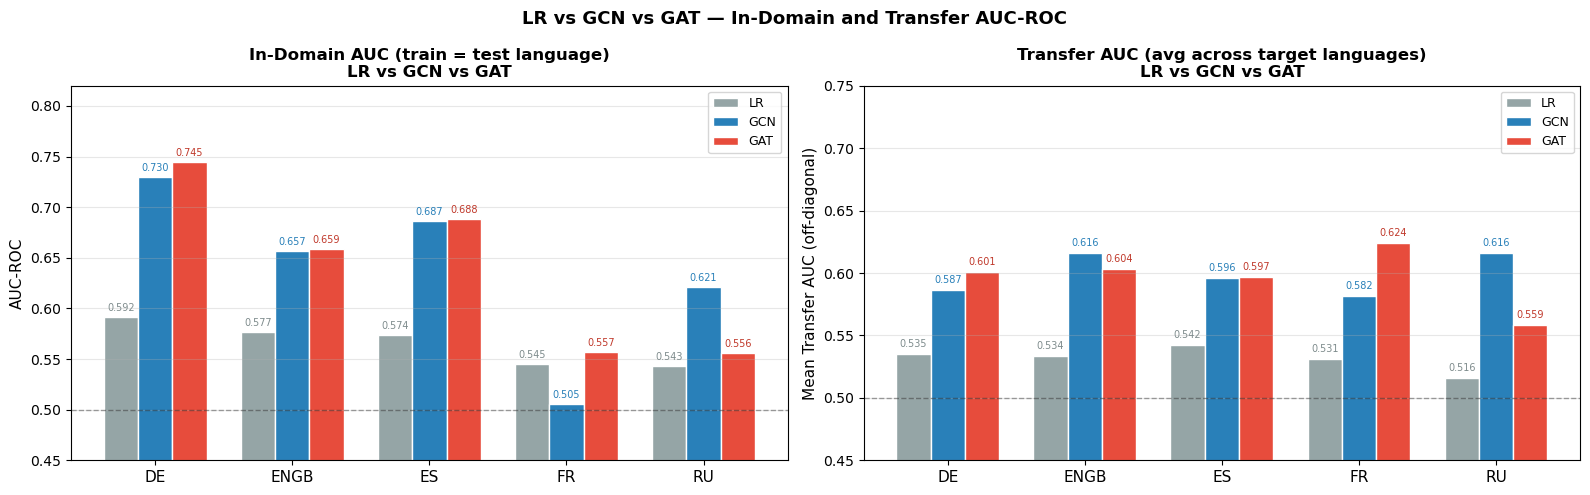

  Saved: final_model_comparison.png


In [24]:
# =============================================================================
# LR TRANSFER LEARNING — train on source features, predict on target features
# Same 5x5 structure as GCN/GAT transfer for fair comparison
# =============================================================================

print("\n" + "=" * 70)
print("  LR TRANSFER LEARNING")
print("=" * 70)
print("""
LR is trained on raw game features of a source language.
Applied directly to target language features — no graph, no fine-tuning.
This is the feature-only transfer baseline.
""")

lr_transfer_results = {}

for source_lang in LANGUAGES:
    data_src = graphs[source_lang]
    X_src = data_src.x.numpy()
    y_src = data_src.y.numpy()

    perm    = np.random.permutation(len(y_src))
    n_train = int(len(y_src) * 0.70)
    n_val   = int(len(y_src) * 0.15)
    train_idx = perm[:n_train]
    test_idx  = perm[n_train + n_val:]

    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(
            max_iter=1000, class_weight="balanced",
            random_state=SEED, C=1.0
        ))
    ])
    clf.fit(X_src[train_idx], y_src[train_idx])

    # In-domain (diagonal)
    probs = clf.predict_proba(X_src[test_idx])[:, 1]
    preds = (probs > 0.5).astype(int)
    lr_transfer_results[(source_lang, source_lang)] = {
        "auc_roc": roc_auc_score(y_src[test_idx], probs),
        "f1":      f1_score(y_src[test_idx], preds, zero_division=0),
    }
    print(f"\n── Source: {source_lang} ──")
    print(f"    {source_lang} -> {source_lang} (in-domain): "
          f"AUC={lr_transfer_results[(source_lang, source_lang)]['auc_roc']:.4f}")

    # Transfer to all other languages (all nodes, no split needed)
    for target_lang in LANGUAGES:
        if target_lang == source_lang:
            continue
        data_tgt = graphs[target_lang]
        X_tgt = data_tgt.x.numpy()
        y_tgt = data_tgt.y.numpy()

        probs = clf.predict_proba(X_tgt)[:, 1]
        preds = (probs > 0.5).astype(int)
        lr_transfer_results[(source_lang, target_lang)] = {
            "auc_roc": roc_auc_score(y_tgt, probs),
            "f1":      f1_score(y_tgt, preds, zero_division=0),
        }
        print(f"    {source_lang} -> {target_lang} (transfer):  "
              f"AUC={lr_transfer_results[(source_lang, target_lang)]['auc_roc']:.4f}")

# Build LR transfer matrix
lr_matrix_auc = pd.DataFrame(index=LANGUAGES, columns=LANGUAGES, dtype=float)
for (src, tgt), metrics in lr_transfer_results.items():
    lr_matrix_auc.loc[src, tgt] = metrics["auc_roc"]

print("\n── LR Transfer Matrix (AUC-ROC) ──")
print(lr_matrix_auc.to_string(float_format="%.3f"))

# =============================================================================
# UPDATED VISUALISATION — LR vs GCN vs GAT, both in-domain and transfer
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
x = np.arange(len(LANGUAGES))
w = 0.25

lr_indomain  = [lr_transfer_results[(l, l)]["auc_roc"]  for l in LANGUAGES]
gcn_indomain = [transfer_results[(l, l)]["auc_roc"]     for l in LANGUAGES]
gat_indomain = [gat_transfer_results[(l, l)]["auc_roc"] for l in LANGUAGES]

lr_transfer_avg = [
    np.mean([lr_matrix_auc.loc[l, t]
             for t in LANGUAGES if t != l])
    for l in LANGUAGES
]
gcn_transfer_avg = [
    np.mean([matrix_auc.astype(float).loc[l, t]
             for t in LANGUAGES if t != l])
    for l in LANGUAGES
]
gat_transfer_avg = [
    np.mean([gat_matrix_auc.astype(float).loc[l, t]
             for t in LANGUAGES if t != l])
    for l in LANGUAGES
]

# ── Left: In-Domain ───────────────────────────────────────────────────────────
axes[0].bar(x - w, lr_indomain,  w, label="LR",  color="#95a5a6", edgecolor="white")
axes[0].bar(x,     gcn_indomain, w, label="GCN", color="#2980b9", edgecolor="white")
axes[0].bar(x + w, gat_indomain, w, label="GAT", color="#e74c3c", edgecolor="white")
axes[0].axhline(0.5, color="black", linestyle="--", alpha=0.35, linewidth=1)
axes[0].set_xticks(x); axes[0].set_xticklabels(LANGUAGES, fontsize=11)
axes[0].set_ylim(0.45, 0.82)
axes[0].set_ylabel("AUC-ROC", fontsize=11)
axes[0].set_title("In-Domain AUC (train = test language)\nLR vs GCN vs GAT",
                  fontweight="bold")
axes[0].legend(fontsize=9); axes[0].grid(axis="y", alpha=0.3)
for i in range(len(LANGUAGES)):
    for val, offset, color in [
        (lr_indomain[i],  -w, "#7f8c8d"),
        (gcn_indomain[i],  0, "#2980b9"),
        (gat_indomain[i], +w, "#c0392b"),
    ]:
        axes[0].text(x[i] + offset, val + 0.004, f"{val:.3f}",
                     ha="center", va="bottom", fontsize=7, color=color)

# ── Right: Transfer (off-diagonal avg) ───────────────────────────────────────
axes[1].bar(x - w, lr_transfer_avg,  w, label="LR",  color="#95a5a6", edgecolor="white")
axes[1].bar(x,     gcn_transfer_avg, w, label="GCN", color="#2980b9", edgecolor="white")
axes[1].bar(x + w, gat_transfer_avg, w, label="GAT", color="#e74c3c", edgecolor="white")
axes[1].axhline(0.5, color="black", linestyle="--", alpha=0.35, linewidth=1)
axes[1].set_xticks(x); axes[1].set_xticklabels(LANGUAGES, fontsize=11)
axes[1].set_ylim(0.45, 0.75)
axes[1].set_ylabel("Mean Transfer AUC (off-diagonal)", fontsize=11)
axes[1].set_title("Transfer AUC (avg across target languages)\nLR vs GCN vs GAT",
                  fontweight="bold")
axes[1].legend(fontsize=9); axes[1].grid(axis="y", alpha=0.3)
for i in range(len(LANGUAGES)):
    for val, offset, color in [
        (lr_transfer_avg[i],  -w, "#7f8c8d"),
        (gcn_transfer_avg[i],  0, "#2980b9"),
        (gat_transfer_avg[i], +w, "#c0392b"),
    ]:
        axes[1].text(x[i] + offset, val + 0.004, f"{val:.3f}",
                     ha="center", va="bottom", fontsize=7, color=color)

plt.suptitle("LR vs GCN vs GAT — In-Domain and Transfer AUC-ROC",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("final_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("  Saved: final_model_comparison.png")

## Conclusion

This project applied Graph Convolutional Networks and Graph Attention Networks
to the Twitch Gamers dataset, asking two questions: can graph structure improve
mature content prediction within a language, and do patterns learned in one
language transfer to others?

### What the Numbers Show

**Graph structure adds genuine signal.** Across four of five languages, both
GCN and GAT substantially outperform the LR baseline in-domain (GCN gains
+0.093 to +0.142 AUC; GAT gains +0.095 to +0.132 AUC). The LR transfer
matrix — where all values sit between 0.49 and 0.59 — establishes that raw
game features alone transfer almost nothing useful across languages. GCN and
GAT transfer matrices consistently reach 0.62–0.74 for non-FR targets,
confirming that graph-augmented representations carry substantially more
cross-language signal than features alone.

**The graph is what enables transfer, not just features.** This is the
clearest finding in the data. LR trained on any source language transfers near
randomly (avg ~0.53 AUC). GCN and GAT trained on the same source data achieve
avg transfer AUC of 0.58–0.62. The shared 3,170-dimensional game vocabulary
provides the bridge, but message passing over the friendship graph is what
builds representations rich enough to generalise.

**GAT and GCN have complementary strengths.** GAT outperforms GCN in-domain
for DE, ENGB, ES, and FR — most notably for FR (+0.052 AUC) where GCN falls
below the LR baseline but GAT recovers to above it. GCN outperforms GAT
in-domain for RU (0.621 vs 0.556), where GAT's attention mechanism overfits
on the smallest, most imbalanced graph. In transfer, GCN is the stronger
source for ENGB and RU; GAT is stronger for FR and DE. Neither architecture
dominates universally.

**FR is a consistent anomaly across all three models.** LR on FR transfers
near-randomly (avg 0.521). GCN in-domain on FR is below random (0.505). GAT
recovers slightly (0.557) but remains the weakest in-domain score. FR as a
GCN transfer source produces avg 0.582 — the worst of any source for GCN.
FR as a GAT source produces 0.624 — the best of any source for GAT, and the
largest model-specific difference in the entire experiment. This confirms that
FR's friendship network contains weak but non-zero content signal, accessible
to attention-based aggregation but not to equal-weight aggregation.

**RU is the opposite case.** RU has the lowest raw feature signal (LR
AUC=0.479 — below random) but the largest graph gain for GCN (+0.142). As a
GCN transfer source, RU achieves avg 0.616 — tied for best. As a GAT source,
RU collapses to avg 0.559, and GAT in-domain on RU (0.556) is far below GCN
(0.621). RU's content signal is real but fragile — graph structure helps GCN
extract it, but GAT's additional parameters overfit on the small training set
and destroy the signal.

### Overall

The shared game vocabulary makes cross-language transfer possible.
Graph neural networks, whether GCN or GAT, make it meaningful, lifting
transfer performance far above the feature-only baseline. The choice between
GCN and GAT depends on graph properties: GAT is preferable for dense graphs
with heterogeneous neighbourhoods, GCN for sparse or small graphs where
simpler aggregation avoids overfitting. FR remains the dataset's fundamental
challenge, no model resolves a community where content type and friendship
structure are largely independent.